In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 05: XGBoost with one-hot NAICS 
XGBoost model, one hot encoded NAICS sector

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [8]:
train_df.shape

(425594, 49)

In [9]:
train_df.drop_duplicates('LoanNr_ChkDgt').shape

(425594, 49)

#### Set the predictor features.  Include one-hot NAICS

In [10]:
predictor_features = setup.predictor_features + [c for c in train_df.columns if c.startswith('NS__')]
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'NS___Accommodation and Food Services', 'NS___Construction', 'NS___Health Care and Social Assistance', 'NS___Manufacturing', 'NS___Other Services (except Public Administration)', 'NS___Professional, Scientific, and Technical Services', 'NS___Retail Trade', 'NS___Wholesale Trade', 'NS___infrequent_sklearn']


In [11]:
train_df[predictor_features].describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,NS___Wholesale Trade,NS___infrequent_sklearn
count,425594.000000,425594.000000,422477.000000,4.255940e+05,425050.000000,342255.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.00000
mean,9.758920,2.172277,0.097807,1.949280e+05,0.279906,0.814930,0.050858,0.100688,0.091348,0.081202,0.097194,0.099376,0.098270,0.186220,0.067374,0.17833
std,63.011166,15.140139,0.297053,2.994808e+05,0.448953,0.388355,0.219709,0.300915,0.288103,0.273145,0.296222,0.299167,0.297679,0.389284,0.250669,0.38279
min,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,3.600000e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.000000,0.000000,0.000000,9.000000e+04,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,9.000000,2.000000,0.000000,2.157000e+05,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9992.000000,5621.000000,1.000000,1.144632e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [12]:
train_df[predictor_features + ['target']].corr()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),"NS___Professional, Scientific, and Technical Services",NS___Retail Trade,NS___Wholesale Trade,NS___infrequent_sklearn,target
NoEmp,1.000000,0.052510,-0.009243,0.093125,-0.038672,0.002058,0.006517,0.014581,0.005411,-0.004541,0.040973,-0.012772,-0.012733,-0.020773,0.002501,-0.004631,-0.027838
CreateJob,0.052510,1.000000,-0.046967,0.101755,0.028831,0.009019,0.036918,0.058003,-0.007401,-0.003143,0.014351,-0.012840,-0.008465,-0.022503,-0.007765,-0.004302,-0.009540
LowDoc,-0.009243,-0.046967,1.000000,-0.133731,0.154037,-0.119292,0.039258,0.008316,-0.028827,0.022709,-0.013189,0.019163,-0.025113,0.048167,-0.026173,-0.018175,-0.076836
DisbursementGross,0.093125,0.101755,-0.133731,1.000000,-0.067410,-0.006023,0.082087,0.072254,-0.042739,0.018038,0.092656,-0.037655,-0.040415,-0.034466,0.056302,-0.050165,-0.122857
new_business,-0.038672,0.028831,0.154037,-0.067410,1.000000,-0.046626,0.136142,0.107992,-0.073849,0.050418,-0.059357,0.026642,-0.035170,0.027689,-0.062140,-0.000276,0.014277
urban_flag,0.002058,0.009019,-0.119292,-0.006023,-0.046626,1.000000,-0.004093,-0.025335,-0.025977,0.016332,-0.019316,0.020045,0.056243,-0.008973,0.033228,-0.026005,0.054391
franchise_flag,0.006517,0.036918,0.039258,0.082087,0.136142,-0.004093,1.000000,0.270444,-0.062259,-0.044932,-0.051366,0.012512,-0.061328,0.002645,-0.053386,-0.023746,-0.011047
NS___Accommodation and Food Services,0.014581,0.058003,0.008316,0.072254,0.107992,-0.025335,0.270444,1.000000,-0.106092,-0.099473,-0.109788,-0.111148,-0.110460,-0.160063,-0.089934,-0.155882,0.011993
NS___Construction,0.005411,-0.007401,-0.028827,-0.042739,-0.073849,-0.025977,-0.062259,-0.106092,1.000000,-0.094259,-0.104033,-0.105322,-0.104670,-0.151673,-0.085220,-0.147711,0.033514
NS___Health Care and Social Assistance,-0.004541,-0.003143,0.022709,0.018038,0.050418,0.016332,-0.044932,-0.099473,-0.094259,1.000000,-0.097543,-0.098751,-0.098140,-0.142211,-0.079903,-0.138495,-0.075505


In [13]:
with open(Path(setup.temp_path).joinpath('05_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Hyperparameter Tune and Fit

In [14]:
mean_target = np.mean(train_df['target'])
scale_pos_wt = (1-mean_target)/mean_target
print(f'target rate: {mean_target}, pos wt: {scale_pos_wt}')

target rate: 0.20307382152943884, pos wt: 3.9243176322214124


##### Do a simple hyperparameter search

In [15]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 10)

In [16]:
hyperparam_serarch = {'max_depth': [4, 5, 6],
                      'min_child_weight': [1, 10, 50],
                      #'scale_pos_weight': list(np.linspace(1, scale_pos_wt, 3)),
                      'gamma': [0, 0.5, 1, 2],
                      'subsample': [0.5, 0.8, 1.0],
                      'learning_rate': [0.01, 0.1, 0.3],
                      'reg_alpha': [0, 0.001, 0.01, 0.1],
                      'reg_lambda': [0.001, 0.01, 0.1, 0.5]
                     }

In [17]:
# Set up a cross validation without the final fit; don't use early stopping yet
random_search = RandomizedSearchCV(xgb_model, hyperparam_serarch,
                                   n_iter=20, 
                                   n_jobs=-1,
                                   random_state=53,
                                   verbose = 0,
                                   refit = False)

In [18]:
# Do the cross validation parameter search
rs_fit = random_search.fit(train_df[predictor_features], train_df['target']);

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [19]:
print(random_search.best_params_)

{'subsample': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 0, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 1}


In [20]:
pd.DataFrame({k:[random_search.best_params_[k]] for k in random_search.best_params_.keys()}) \
    .to_csv(Path(setup.temp_path).joinpath('05_REPORT_fit_parameter_selected.csv'), index=False)

##### Do a final fit with the full training data 

In [21]:
best_params = dict(random_search.best_params_, 
                   **{'objective':"binary:logistic", 'n_estimators':20})

In [22]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 20)

In [23]:
xgb_model = xgb_model.set_params(**random_search.best_params_)

In [24]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50659	validation_1-logloss:0.50947
[1]	validation_0-logloss:0.50587	validation_1-logloss:0.50874
[2]	validation_0-logloss:0.50515	validation_1-logloss:0.50802
[3]	validation_0-logloss:0.50445	validation_1-logloss:0.50731
[4]	validation_0-logloss:0.50375	validation_1-logloss:0.50661
[5]	validation_0-logloss:0.50307	validation_1-logloss:0.50592
[6]	validation_0-logloss:0.50240	validation_1-logloss:0.50525
[7]	validation_0-logloss:0.50174	validation_1-logloss:0.50458
[8]	validation_0-logloss:0.50110	validation_1-logloss:0.50393
[9]	validation_0-logloss:0.50046	validation_1-logloss:0.50329
[10]	validation_0-logloss:0.49983	validation_1-logloss:0.50266
[11]	validation_0-logloss:0.49922	validation_1-logloss:0.50203
[12]	validation_0-logloss:0.49861	validation_1-logloss:0.50142
[13]	validation_0-logloss:0.49801	validation_1-logloss:0.50082
[14]	validation_0-logloss:0.49743	validation_1-logloss:0.50023
[15]	validation_0-logloss:0.49685	validation_1-logloss:0.49965
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
train_df['target'].value_counts()

target
0    339167
1     86427
Name: count, dtype: int64

##### Save the model

In [26]:
xgb_model.save_model(Path(setup.temp_path).joinpath('05_MODEL_xgboost.json'))

In [27]:
with open(Path(setup.temp_path).joinpath('05_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [28]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [29]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.225201,0.020157,0.193389,0.305768,0.223881
1,0.239222,0.015820,0.193389,0.305768,0.249492


## Decision Threshold
Max f1, on training data

In [30]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [31]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [32]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('05_REPORT_thresh_tune.csv'), index=False)

In [33]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.425483
12,0.24,0.420175


##### Apply decision threshold
All datasets

In [34]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [35]:
pred_df['predict_bin'].value_counts()

predict_bin
1    408738
0    279343
Name: count, dtype: int64

In [36]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('05_DATA_combined_predictions.parquet'))

## Metrics

In [37]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('05_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.548517,0.425683,0.285718,0.834460,0.318935,0.701326,NaN
1,train,0.540769,0.425483,0.285197,0.837389,0.319831,0.698646,NaN
2,val,0.542522,0.428935,0.288468,0.836036,0.323772,0.699656,NaN
0,test,0.541789,0.426576,0.286268,0.836634,0.319949,0.698165,0.0
1,test,0.569341,0.422721,0.283893,0.827271,0.315771,0.710682,1.0


## Lift
Test data

In [38]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

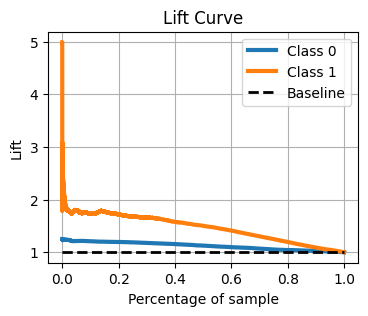

In [39]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('05_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [40]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [41]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('05_REPORT_importance_gain.csv'), index=True)

In [42]:
feat_impgain.head()

,importance
urban_flag,5208.554688
DisbursementGross,795.363281
LowDoc,452.499817
NS___Health Care and Social Assistance,339.498535
NoEmp,94.836876


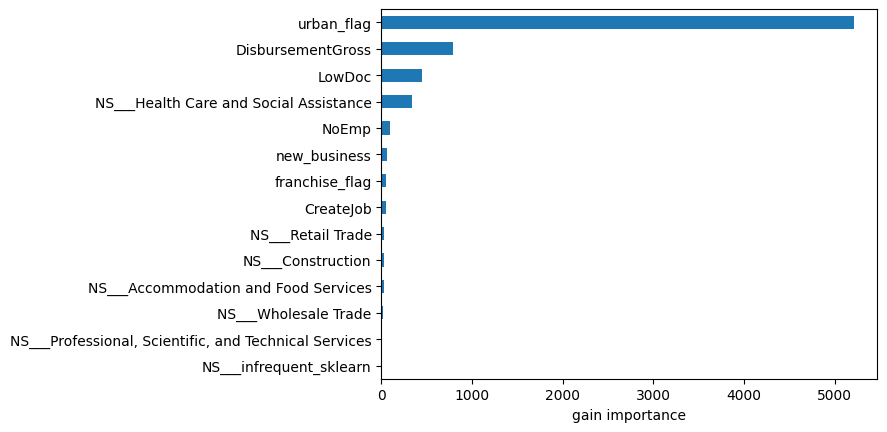

In [43]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('05_PLOT_importance_gain.png'))

##### Permutation Importance

In [44]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [45]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [46]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.053971,0.053971
5,urban_flag,0.041341,0.041341
2,LowDoc,0.009943,0.009943
1,CreateJob,0.009770,0.009770
9,NS___Health Care and Social Assistance,0.009028,0.009028


In [47]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('05_DATA_importance_perturb.csv'),
            index=False)

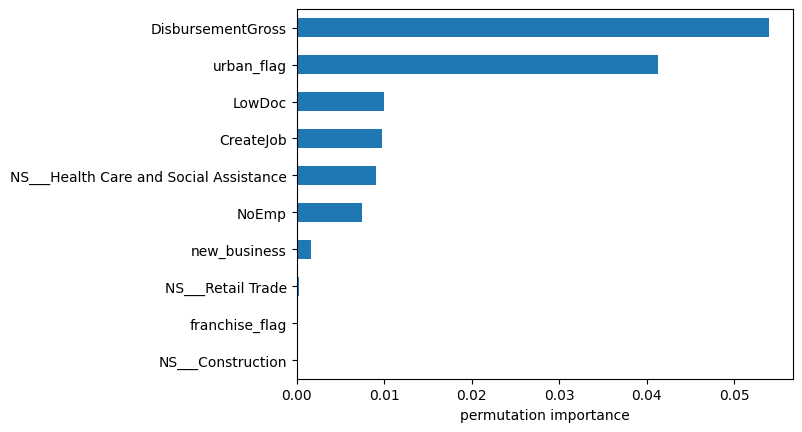

In [48]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('05_PLOT_importance_perturb.png'))

## PDP Plot - NAICS one hot

In [57]:
naics_features = list(train_df.filter(like='NS__').columns)

In [51]:
results = partial_dependence(xgb_model, train_df[predictor_features], ['NS___Accommodation and Food Services'])
pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [52]:
plt.close()

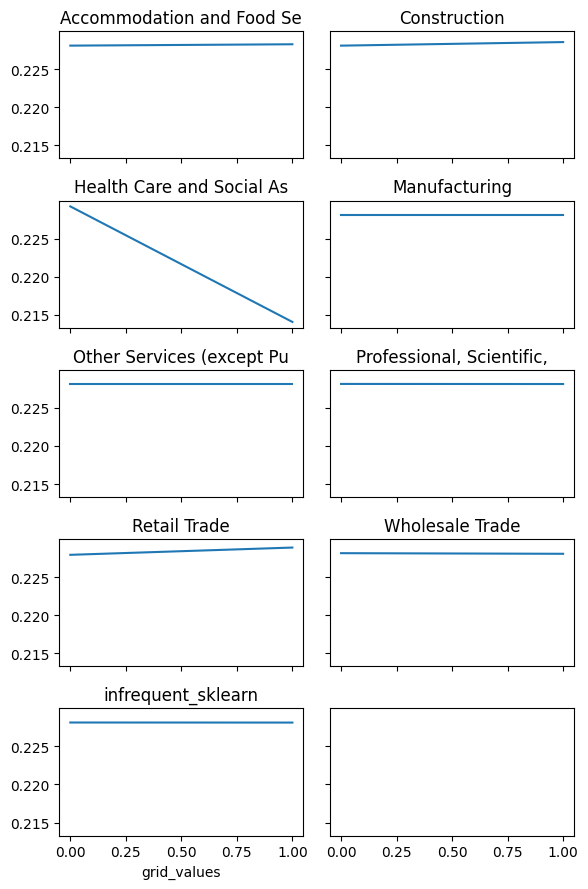

In [59]:
fig, ax = plt.subplots(int(np.ceil(len(naics_features)/2)), 2, sharex=True, sharey=True, figsize=(6, 9))
for i in range(len(naics_features)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    results = partial_dependence(xgb_model, train_df[predictor_features], 
                                 [naics_features[i]])
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('05_PLOT_pdp_naics_onehot.png'),
               bbox_inches='tight')
plt.show()